In [1]:
import os
import sys
sys.path.append('../')

import random as rn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import KFold

import tensorflow as tf

from src.utils.models import define_model, train_and_pred
from src.utils.data import load_data

pd.options.display.max_columns = 100
%matplotlib inline
plt.style.use('seaborn')

/home/hardian_lawi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/fchollet/keras/issues/2280#issuecomment-306959926

def init_seeds(seed):

    os.environ['PYTHONHASHSEED'] = '0'

    # The below is necessary for starting Numpy generated random numbers
    # in a well-defined initial state.

    np.random.seed(seed)

    # The below is necessary for starting core Python generated random numbers
    # in a well-defined state.

    rn.seed(seed)

    # Force TensorFlow to use single thread.
    # Multiple threads are a potential source of
    # non-reproducible results.
    # For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

    session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

    from keras import backend as K

    # The below tf.set_random_seed() will make random number generation
    # in the TensorFlow backend have a well-defined initial state.
    # For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

    tf.set_random_seed(seed)

    sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
    
    K.set_session(sess)
    
    return sess

try:
    del sess
except:
    pass

print('creating new session.')
sess = init_seeds(0)

creating new session.


Using TensorFlow backend.


In [3]:
radiant_cols = ['hero_' + str(i) for i in range(5)]
dire_cols = ['hero_' + str(i) for i in range(5, 10)]
no_heroes = 116

radiants, dires, df = load_data()

## Calculate Best Accuracy

Iter 0
Train pos pctg 0.5376726663876099
Test pos pctg 0.5424863959815822
-------------------------------------------------

Instructions for updating:
Colocations handled automatically by placer.
custom_nn == train: 0.5981 - test: 0.5629
custom_nn_l2_regularizer == train: 0.5980 - test: 0.5758
custom_nn_dropout == train: 0.5985 - test: 0.5751
nn_l2_regularizer == train: 0.5701 - test: 0.5761
nn_dropout == train: 0.5734 - test: 0.5643

Iter 1
Train pos pctg 0.5393121250174411
Test pos pctg 0.5359285614622575
-------------------------------------------------

custom_nn == train: 0.6016 - test: 0.5747
custom_nn_l2_regularizer == train: 0.5987 - test: 0.5726
custom_nn_dropout == train: 0.5943 - test: 0.5703
nn_l2_regularizer == train: 0.5712 - test: 0.5596
nn_dropout == train: 0.5717 - test: 0.5601

Iter 2
Train pos pctg 0.5378121947816381
Test pos pctg 0.5419282824054695
-------------------------------------------------

custom_nn == train: 0.6011 - test: 0.5666
custom_nn_l2_regularizer 

Text(0, 0.5, 'Validation Accuracy')

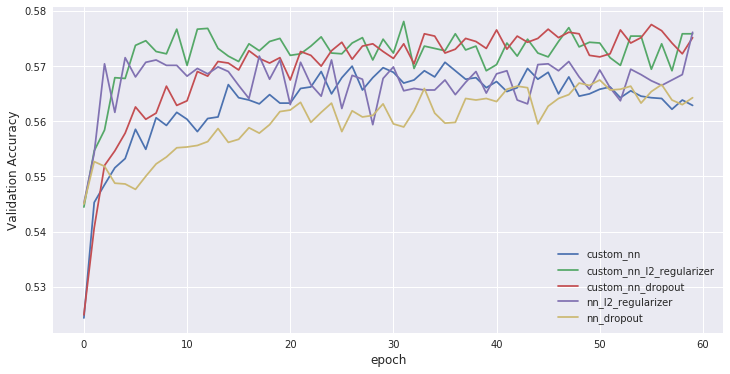

In [4]:
n_splits = 5
kf = KFold(n_splits, shuffle=True, random_state=10)

print('=================================================')

avg_score = {}
scores = {}

histories = {}

for i, (train_idx, test_idx) in enumerate(kf.split(df)):
    
    X_train = [radiants.iloc[train_idx].copy(), dires.iloc[train_idx].copy()]
    X_test = [radiants.iloc[test_idx].copy(), dires.iloc[test_idx].copy()]

    y_train = df.radiant_win.iloc[train_idx].values
    y_test = df.radiant_win.iloc[test_idx].values
    
    print('Iter', i)
    print('Train pos pctg', y_train.mean())
    print('Test pos pctg', y_test.mean())
    print('-------------------------------------------------\n')
    
    models_dict = {
        'custom_nn': [
            define_model(name='custom_nn', optimizer='adam', seed=0),
        ],
        'custom_nn_l2_regularizer': [
            define_model(name='custom_nn_l2_regularizer', optimizer='adam', seed=0, alpha=0.001),
        ],
        'custom_nn_dropout': [
            define_model(name='custom_nn_dropout', optimizer='adam', seed=0, dropout_rate=0.3),
        ],
        'nn_l2_regularizer': [
            define_model(name='nn_l2_regularizer', optimizer='adam', seed=0, alpha=0.01),
        ],
        'nn_dropout': [
            define_model(name='nn_dropout', optimizer='adam', seed=0, dropout_rate=0.5),
        ],
    }
    
    if i not in histories:
        histories[i] = {}
        
    scores[i] = {}
    
    for key, models in models_dict.items():
        
        if key not in avg_score:
            avg_score[key] = dict(train=0, test=0)
            
        if key not in histories[i]:
            histories[i][key] = {}
            
        temp_preds = train_and_pred(models, X_train, y_train, X_test, y_test, key)
        temp_scores = accuracy_score(y_train, temp_preds[0] > 0.5), \
            accuracy_score(y_test, temp_preds[1] > 0.5)
        
        avg_score[key]['train'] += temp_scores[0]
        avg_score[key]['test'] += temp_scores[1]
        
        scores[i][key] = temp_scores[1]

        print(key, '==', 
              'train: %.4f' % temp_scores[0], '-',
              'test: %.4f' % temp_scores[1])
        
        histories[i][key].update(temp_preds[2].history)

    print('=================================================\n')
          
############################################################################

print('Average score\n--------------------')
for key, models in models_dict.items():
    print(key, '=======', 
          'train:', avg_score[key]['train'] / n_splits, '----',
          'test:', avg_score[key]['test'] / n_splits)
    
reform_3 = {(metric, fold, model): values 
          for fold, interDict in histories.items() 
          for model, innerDict in interDict.items()
          for metric, values in innerDict.items()}

reform_3 = pd.DataFrame(reform_3)

reform_3['val_acc'].max(axis=0).groupby(level=1).mean()

reform_3['val_acc'][0].plot(figsize=(12, 6))
plt.xlabel('epoch', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)